# Plots for Presentation/Report - SETUP

- small world graph with propagated signal
- distribution of training graphs: n_nodes vs. clustering coefficient
- Signal Propagation - for SI, different mean_sources: n_nodes vs. anteil infected

In [57]:
GRAPH_TYPE = "watts_strogatz" # "watts_strogatz" or "barabasi_albert"
PROP_MODEL = "SI"  # "SIR" or "SI"
TRAINING_SIZE = 500
VALIDATION_SIZE = 0
MEAN_N_NODES = 1000
WS_NEIGHBOURS = 10
WS_PROBABILITY = 0.2
BA_NEIGHBOURS = 3
MEAN_SOURCES = [1, 3]
ITERATIONS = 50
SMALL_INPUT = False


In [58]:
""" Creates a data set of graphs with modeled signal propagation for training and validation."""
import os
import random
from pathlib import Path
import numpy as np
import ndlib.models.epidemics as epidemic_model
import ndlib.models.ModelConfig as mc
import networkx as nx
from tqdm import tqdm
from torch_geometric.data import Data
import torch


def select_random_sources(graph: nx.Graph, sources, select_random: bool = True) -> list:
    """
    Selects nodes from the given graph as sources.
    The amount of nodes is randomly selected from a
    normal distribution with mean mean_sources and std mean_sources/2.
    :param graph: graph to select sources from
    :return: list of source nodes
    """
    if select_random:
        mu = sources
        sigma = int(np.sqrt(mu))
        n_sources = np.random.normal(mu, sigma)
        # make sure there are no sources smaller than 1 or larger than 1/4 of the graph
        n_sources = np.clip(n_sources, 1, len(graph.nodes) / 4).astype(int)
    else:
        n_sources = sources
    return random.choices(list(graph.nodes), k=n_sources)


def create_graph(graph_type: str) -> nx.Graph:
    """
    Creates a graph of the given type.
    :param graph_type: type of graph to create
    :return: created graph
    """
    n = np.random.normal(MEAN_N_NODES, np.sqrt(MEAN_N_NODES / 2))
    n = np.maximum(1, n).astype(int)

    if graph_type == "watts_strogatz":
        graph = nx.watts_strogatz_graph(n, WS_NEIGHBOURS, WS_PROBABILITY)
    elif graph_type == "barabasi_albert":
        graph = nx.barabasi_albert_graph(n, BA_NEIGHBOURS)
    else:
        raise ValueError("Unknown graph type")

    return graph


def create_signal_propagation_model(graph: nx.Graph, sources, model_type: str) -> epidemic_model:
    """
    Creates a signal propagation model of the given type for the given graph.
    :param graph: graph to create the model for
    :param model_type: type of model to create
    :return: created model
    """
    source_nodes = select_random_sources(graph, sources)
    beta = np.random.uniform(0.015, 0.02)

    config = mc.Configuration()
    if model_type == "SI":
        prop_model = epidemic_model.SIModel(graph)
        config.add_model_parameter("beta", beta)

    elif model_type == "SIR":
        gamma = np.random.uniform(0.1, beta)
        prop_model = epidemic_model.SIRModel(graph)
        config.add_model_parameter("beta", beta)
        config.add_model_parameter("gamma", gamma)

    else:
        raise ValueError("Unknown model type")

    config.add_model_initial_configuration("Infected", source_nodes)
    prop_model.set_initial_status(config)
    iterations = prop_model.iteration_bunch(ITERATIONS)
    prop_model.build_trends(iterations)

    return prop_model, beta


def create_data_set(
    n_graphs: int,
    sources,
    graph_type: str = GRAPH_TYPE,
    model_type: str = PROP_MODEL,
):
    """
    Creates n graphs of type graph_type and runs a
    signal propagation model of type model_type on them.
    The graphs and the results of the signal propagation are saved to the given path.
    :param n_graphs: number of graphs to create
    :param graph_type: type of graph to create
    :param model_type: type of model to use for signal propagation
    """

    path = Path(f"data/{sources}")
    Path(path).mkdir(parents=True, exist_ok=True)
    for file_name in os.listdir(path):
        os.remove(os.path.join(path, file_name))

    for i in tqdm(range(n_graphs), disable=False):
        graph = create_graph(graph_type)
        prop_model, beta = create_signal_propagation_model(graph, sources, model_type)
        X = torch.tensor(list(prop_model.status.values()), dtype=torch.float)
        y = torch.tensor(list(prop_model.initial_status.values()), dtype=torch.float)
        edge_index = (
            torch.tensor(list(graph.to_directed().edges), dtype=torch.long)
            .t()
            .contiguous()
        )
        data = Data(x=X, y=y, edge_index=edge_index, beta=beta)
        data.validate()
        torch.save(data, path / f"{i}.pt")


def main():
    """
    Creates a data set of graphs with modeled signal propagation for training and validation.
    """
    print("Create Data:")
    for sources in MEAN_SOURCES:
        create_data_set(TRAINING_SIZE + VALIDATION_SIZE, sources)


if __name__ == "__main__":
    main()


Create Data:


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:28<00:00,  5.64it/s]


## small world graph with propagated signal

- create data with few nodes
- set layout to cirular in visualization
- copy plots from there

## distribution of training graphs: n_nodes vs. clustering coefficient
(Local Clustering Coefficient of a node in a Graph is the fraction of pairs of the node’s neighbours that are adjacent to each other.)
- create graphs with settings used in training, than execute the following code

In [59]:
# load graphs from data/raw
# create scatter plot with densitiy curves at the axis that pots the number of
# nodes agains the clustering coefficient. The clustering coefficient has to be
# calculated for each graph.

import os
import torch
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

raw_data_path = Path("data/3/")
raw_data_paths = os.listdir(raw_data_path)
ccs = []
n_nodes = []

for file in tqdm(raw_data_paths):
    data = torch.load(Path(raw_data_path, file))
    graph = to_networkx(data)
    n_nodes.append(data.num_nodes)
    ccs.append(nx.average_clustering(graph))


100%|██████████| 500/500 [00:52<00:00,  9.61it/s]


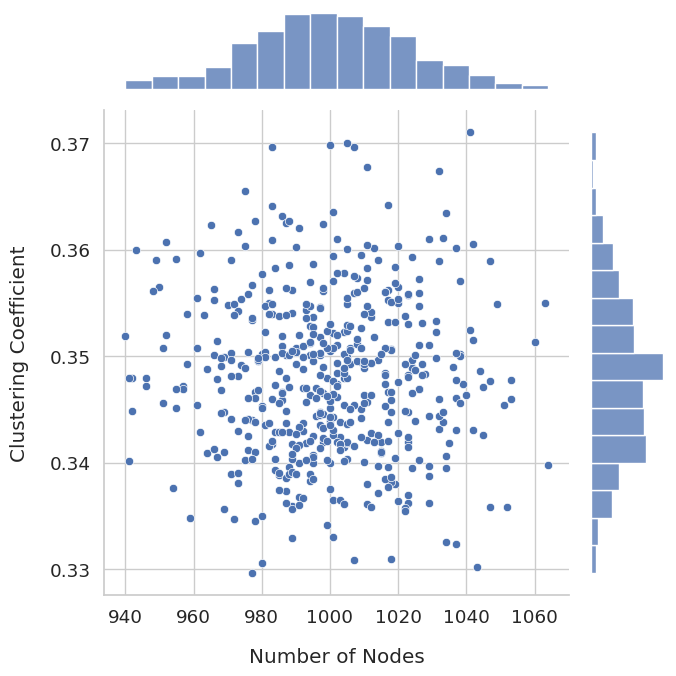

In [60]:
# create scatter plot with densitiy curves at the axis that plots the number of
# nodes agains the clustering coefficient.
# add legend and labels

df = pd.DataFrame({"n_nodes": n_nodes, "clustering coefficient": ccs})

# Set the style
sns.set(style="whitegrid", font_scale=1.2)

# Create the plot
g = sns.jointplot(x="n_nodes", y="clustering coefficient", data=df, kind="scatter", height=7, space=0)

# # Customize the plot
g.ax_marg_x.set_axis_off()  # Hide x-axis marginal plot
g.ax_marg_y.set_axis_off()  # Hide y-axis marginal plot

# Set plot title and axis labels
g.set_axis_labels("Number of Nodes", "Clustering Coefficient", labelpad=15)

# Show the plot
plt.tight_layout()
plt.show()

## Signal Propagation - for SI, different mean_sources: n_nodes vs. anteil infected

- jeweils für 1, 3, 8 sources einen datensatz erstellen und unter data abspeichern
- dann skript ausführen


In [61]:
# load graphs from data/1, data/3, data/8
# create scatter plot with densitiy curves at the axis that pots the number of
# nodes against the number of infected nodes.
# The data from every folder has to be plotted in a different color.
# add legend and labels

import os
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

data_path = Path("data")
df = pd.DataFrame()

for i in MEAN_SOURCES:
    raw_data_path = Path(data_path, str(i))
    raw_data_paths = os.listdir(raw_data_path)

    for file in tqdm(raw_data_paths):
        data = torch.load(Path(raw_data_path, file))
        df = df.append({"p_infected": int(torch.sum(data.x))/data.num_nodes, "beta": data.beta, "i": i}, ignore_index=True)

df

100%|██████████| 500/500 [00:00<00:00, 590.03it/s]


,p_infected,beta,i
0,0.554589,0.018820,1.0
1,0.210843,0.015607,1.0
2,0.450389,0.019666,1.0
3,0.116766,0.016909,1.0
4,0.042355,0.015220,1.0
...,...,...,...
995,0.378000,0.016526,3.0
996,0.508016,0.019946,3.0
997,0.337810,0.018347,3.0
998,0.469925,0.018297,3.0


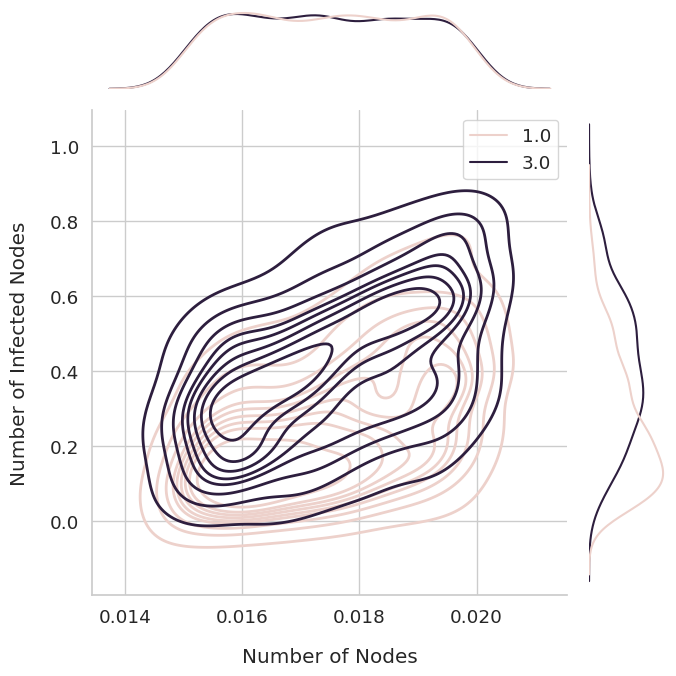

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid", font_scale=1.2)

beta = np.array(df["beta"], dtype=float)
p_infected = np.array(df["p_infected"], dtype=float)
i = np.array(df["i"], dtype=float)

# Create the plot where the data from every folder has to be plotted in a different color.
g = sns.jointplot(
    x=beta,
    y=p_infected,
    hue=i,
    kind="kde",
    height=7,
    space=0,
    # palette=sns.color_palette("tab10"),  # Use the custom color palette
    linewidths=2,  # Increase the linewidth of the KDE contours
)

# Customize the plot
g.ax_marg_x.set_axis_off()  # Hide x-axis marginal plot
g.ax_marg_y.set_axis_off()  # Hide y-axis marginal plot

# Set plot title and axis labels
g.set_axis_labels("Number of Nodes", "Number of Infected Nodes", labelpad=15)

# Show the plot
plt.tight_layout()
plt.show()